<a href="https://colab.research.google.com/github/RVasconcelosMiguel/PROG2-TP1/blob/main/ML_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Body>   
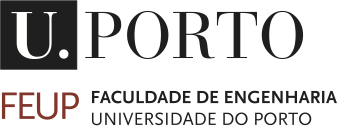   
<h1> <b>Machine Learning 2023/2024 (2<sup>nd</sup> semester) </b> </h1>
<p>Master in Electrical and Computer Engineering </p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt),
**Aníbal Matos** (anibal@fe.up.pt),
**Andry Pinto** (amgp@fe.up.pt),
**Daniel Campos** (dfcampos@fe.up.pt),
**Maria Inês Pereira** (maria.ines@fe.up.pt)

FEUP, Mar. 2024

---


# **Project #02**

**Note:** This work is to be done in group of **2** elements. Use this notebook to answer all the questions. At the end of the work, you should **upload** the **notebook** and a **pdf file** with a printout of the notebook with all the results in the **moodle** platform.
To generate the pdf file we have first to covert the notebook to html using the command `!jupyter nbconvert --to html "ML_project2.ipynb"`, then open the html file and printout to PDF.

**Deadlines:** Present you work (and answer questions) on the week of **May 20** in your corresponding practical class. Upload the files until 23:59 of **May 31, 2024**.


---



# **Identification**

* **Group:** A04_B
* **Name:** Bernardo de Almeida Soeiro
* **Student Number:**up202008204

* **Name:**Rodrigo de Vasconcelos e Miguel
* **Student Number:**up202008406


---




**Initial setup:** To download the data files, run the next cell.

In [ ]:
!wget -O data-setMLproject2.zip https://www.dropbox.com/s/hnyhgqlj5lcqyqr/data-setMLproject2.zip?dl=0 --quiet
!unzip data-setMLproject2.zip -d.


Archive:  data-setMLproject2.zip
  inflating: ./data_test.csv         
  inflating: ./__MACOSX/._data_test.csv  
  inflating: ./data_test2obs.csv     
  inflating: ./__MACOSX/._data_test2obs.csv  
  inflating: ./data_train.csv        
  inflating: ./__MACOSX/._data_train.csv  


# **Main goal**

Consider the following scenario: A mobile robot aims to build a map of the environment with **semantics**, meaning that the robot should be capable to classify the objects nearby. The robot is travelling around and carries on-board a 2D LIDAR measurement device that obtains range measurements at each sample time $t=0, 0.1, 0.2, \ldots$ The following cell shows an example of the type of data:


In [ ]:
import pandas as pd
df_test2obs = pd.read_csv('data_test2obs.csv', index_col=0)
df_test2obs.head(5)
#df

# By convention, zero values mean no range measurements.
# The units are:
# [m] for px and py (position of the robot)
# [m] for the LIDAR ranges

,px,py,angle -179,angle -178,angle -177,angle -176,angle -175,angle -174,angle -173,angle -172,...,angle 171,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180
0,-4.00,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-3.98,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.96,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.94,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.92,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note that the LIDAR measurements consist of range (distance) from the robot to a possible obstacle for each degree of direction, that is,
$$
r_t = \{r_\beta + \eta_r : \beta=-179^o, -178^o, \ldots, 0^o, \ldots, 180^o\}
$$
where $\eta_r$ is assumed to be Gaussian noise. If there is no obstacle within the direction of the laser range or if it is far away, that is, if the distance is greater than $5\,m$, by convention the range measurement is set to zero. Moreover, with a small probability, the range measurements could be corrupted with *outliers*.

The next figure shows $r_t$ as a function of the angle $\beta$ taken at time $t=1.0\,s$.


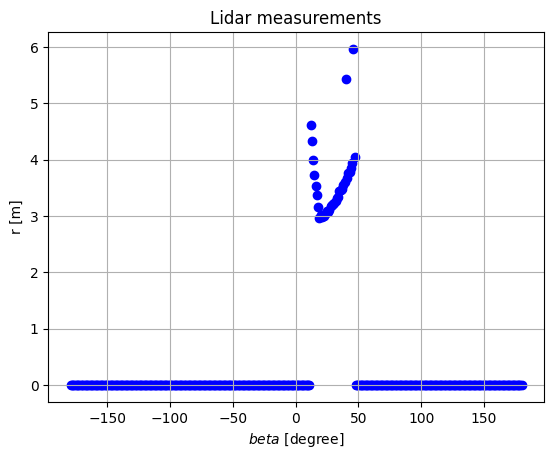

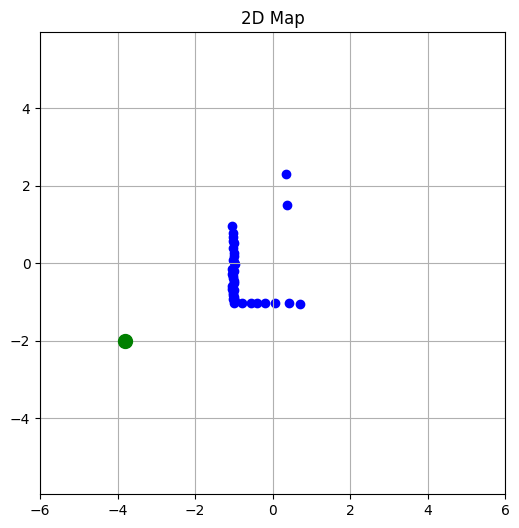

In [ ]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt

Lidar_range = df_test2obs.iloc[:, np.arange(2,362,1)].values
px = df_test2obs["px"].values
py = df_test2obs["py"].values

t=1*10 #1sec times number of samples/second
angle = np.linspace(-179, 180, num=360)

plt.figure()
plt.scatter(angle, Lidar_range[t], color='b')
plt.title('Lidar measurements')
plt.ylabel('r [m]')
plt.xlabel('$beta$ [degree]')
plt.grid();
plt.show()

#Build the cloud points in 2D plan
x_o, y_o = [], []
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')
xdim, ydim = 5, 5
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
plt.grid()

plt.scatter(x_o, y_o, color='b')
plt.title('2D Map');
plt.show()

Note that it may be possible to have more than one object in the range of the LIDAR. \\
Here goes an example when $t=32\,s$:


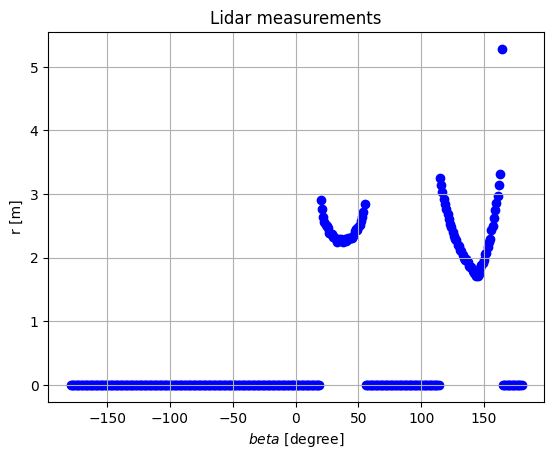

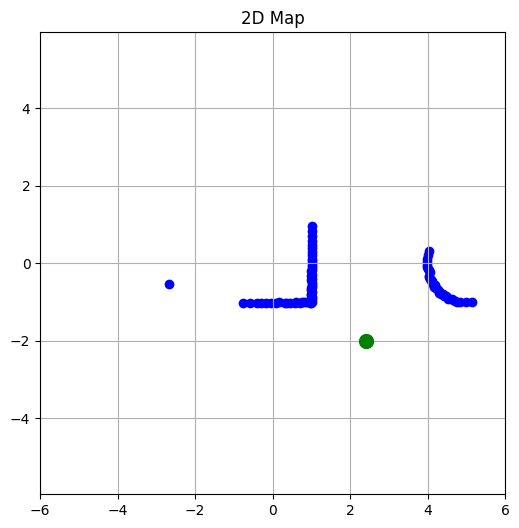

In [ ]:
t=32*10 #5sec times number of samples/second
angle = np.linspace(-179, 180, num=360)

plt.figure()
plt.scatter(angle, Lidar_range[t], color='b')
plt.title('Lidar measurements')
plt.ylabel('r [m]')
plt.xlabel('$beta$ [degree]')
plt.grid();
plt.show()

#Build the cloud points in 2D plan
x_o, y_o = [], []
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')
xdim, ydim = 5, 5
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
plt.grid()

plt.scatter(x_o, y_o, color='b')
plt.title('2D Map');
plt.show()

# **Part 1: Classification of one object**

At this point, the goal is to classify only one object that could be a square or a circle at each LIDAR snapshot. To this end, it was performed a set of 4 experiments for each obstacle (alone) where in each experiment the robot travelled during $40\,s$ with a constant speed and constant direction (horizontal line segment from left to right) from the initial position $(p_x, p_y) = (-4, \bar y)$ to the final position $(p_x, p_y) = (4, \bar y)$, where $\bar y = -4, -3, -2, -1\, m$ \\
The obstacle (circle and square) were placed at the center of the origin $(0,0)$. \\
All the experiments were combined in a unique dataset and then randomly split into two datasets: the trainning data set (70%) and the testing data set (30%). The content of each data set are displayed next.

In [ ]:
import pandas as pd
df_train = pd.read_csv('data_train.csv', index_col=0)
df_train

,px,py,angle -179,angle -178,angle -177,angle -176,angle -175,angle -174,angle -173,angle -172,...,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180,label
0,-3.06,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.48,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.58,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-3.10,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.48,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2.60,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2236,-2.12,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2237,-2.80,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2238,1.18,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
import pandas as pd
df_test = pd.read_csv('data_test.csv', index_col=0)
df_test

,px,py,angle -179,angle -178,angle -177,angle -176,angle -175,angle -174,angle -173,angle -172,...,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180,label
0,-3.46,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
1,0.38,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2,2.58,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
3,-2.84,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
4,-2.56,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,3.32,-1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.752938,2.789123,2.869662,2.960473,3.041882,3.292784,0.0,0.0,0.0,1.0
956,3.62,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
957,2.20,-1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.381054,1.557405,1.728042,2.111385,2.553902,0.000000,0.0,0.0,0.0,2.0
958,-2.98,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


Note that there is an extra column (the label column) that indicates if the obstacle is a **circle (label 1)** or a **square (label 2)**.

**1.1**
Implement a **$k$-nearest neighbor ($k$-NN)** classifier that receives the parameter $k$, the sample to classify (that are the range measurements at one snapshot), and a set of labeled training data. \\
Do not use sklearn or similar packages (use the results of notebook #7).

In [ ]:
# To complete

X_train = df_train.iloc[:, np.arange(2,362,1)].values
Y_train = df_train["label"].values
data_train = df_train.iloc[:, np.arange(2,363,1)].values  #it also includes the label

# KNN

def vector2norm(x, data):
  npoints = data.shape[0]
  distances = np.zeros(npoints)
  data_without_last_column = data[:, :-1]
  for i in range(npoints) :
    sum=0
    #for j in range(len(x)):
      #sum=sum+(x[j]-data[i][j])**2
    squared_diff = np.sum((data_without_last_column[i] - x) ** 2)
    distances[i] = np.sqrt(squared_diff)
  return distances


def kNN_classifier(k,x,data):
  npoints = data.shape[0]
  # compute distance to training points
  dist = vector2norm(x,data)
  # sort along increasing distances
  #  ind = ...
  #  classes = ...
  ind = np.argsort(dist,axis=0)
  classes = data[:, 360]

  classes_sorted = classes[ind]
  # determine class with more element in the k neighborhood
  c1 = 0
  c2 = 0
  for i in range(k):
    #print(classes_sorted[i])
    if classes_sorted[i]==1.0:
      c1=c1+1
    else:
      c2=c2+1
  if c1>c2:
    return 1
  else:
    return 2


**1.2**
Test the $k$-NN classifier for the `data_train.csv` set and for the `data_test.csv` set and obtain the respectively accuracy for $k=1,3,5,7,9$ \\
Note that accuracy is defined as
$$acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$$

where TP are the true positives, TN true negatives, FP false positives, and FN the fale negatives.


In [ ]:
# To complete

# Let's check for all trainning data

data_train = np.append(X_train, np.reshape(Y_train, (len(Y_train), 1)), axis=1)

#K=1
classification = []
correct=0
incorrect=0
for t in range(len(X_train)):
 #  classification.append(...)
  res=kNN_classifier(1, X_train[t], data_train)
  classification.append(res)
  if res==Y_train[t]:
    correct = correct+1
  else:
    incorrect=incorrect +1

acc = correct/(correct+incorrect)
print(f"Accuracy of the model(Training data,k=1): {100.0*acc:4.2f}%")

#K=3
classification = []
correct=0
incorrect=0
for t in range(len(X_train)):
 #  classification.append(...)
  res=kNN_classifier(3, X_train[t], data_train)
  classification.append(res)
  if res==Y_train[t]:
    correct = correct+1
  else:
    incorrect=incorrect +1

acc = correct/(correct+incorrect)
print(f"Accuracy of the model(Training data,k=3): {100.0*acc:4.2f}%")

#K=5
classification = []
correct=0
incorrect=0
for t in range(len(X_train)):
 #  classification.append(...)
  res=kNN_classifier(5, X_train[t], data_train)
  classification.append(res)
  if res==Y_train[t]:
    correct = correct+1
  else:
    incorrect=incorrect +1

acc = correct/(correct+incorrect)
print(f"Accuracy of the model(Training data,k=5): {100.0*acc:4.2f}%")

#K=7
classification = []
correct=0
incorrect=0
for t in range(len(X_train)):
 #  classification.append(...)
  res=kNN_classifier(7, X_train[t], data_train)
  classification.append(res)
  if res==Y_train[t]:
    correct = correct+1
  else:
    incorrect=incorrect +1

acc = correct/(correct+incorrect)
print(f"Accuracy of the model(Training data,k=7): {100.0*acc:4.2f}%")

#K=9
classification = []
correct=0
incorrect=0
for t in range(len(X_train)):
 #  classification.append(...)
  res=kNN_classifier(9, X_train[t], data_train)
  classification.append(res)
  if res==Y_train[t]:
    correct = correct+1
  else:
    incorrect=incorrect +1

acc = correct/(correct+incorrect)
print(f"Accuracy of the model(Training data,k=9): {100.0*acc:4.2f}%")


# Let's check for the testing data
X_test = df_test.iloc[:, np.arange(2,362,1)].values
Y_test = df_test["label"].values

data_test = np.append(X_test, np.reshape(Y_test, (len(Y_test), 1)), axis=1)

#K=1
classification = []
correct=0
incorrect=0
for t in range(len(X_test)):
 #  classification.append(...)
  res=kNN_classifier(1, X_test[t], data_test)
  classification.append(res)
  if res==Y_test[t]:
    correct = correct+1
  else:
    incorrect=incorrect +1

acc = correct/(correct+incorrect)
print(f"Accuracy of the model(Test data,k=1): {100.0*acc:4.2f}%")

#K=3
classification = []
correct=0
incorrect=0
for t in range(len(X_test)):
 #  classification.append(...)
  res=kNN_classifier(3, X_test[t], data_test)
  classification.append(res)
  if res==Y_test[t]:
    correct = correct+1
  else:
    incorrect=incorrect +1

acc = correct/(correct+incorrect)
print(f"Accuracy of the model(Test data,k=3): {100.0*acc:4.2f}%")

#K=5
classification = []
correct=0
incorrect=0
for t in range(len(X_test)):
 #  classification.append(...)
  res=kNN_classifier(5, X_test[t], data_test)
  classification.append(res)
  if res==Y_test[t]:
    correct = correct+1
  else:
    incorrect=incorrect +1

acc = correct/(correct+incorrect)
print(f"Accuracy of the model(Test data,k=5): {100.0*acc:4.2f}%")

#K=7
classification = []
correct=0
incorrect=0
for t in range(len(X_test)):
 #  classification.append(...)
  res=kNN_classifier(7, X_test[t], data_test)
  classification.append(res)
  if res==Y_test[t]:
    correct = correct+1
  else:
    incorrect=incorrect +1

acc = correct/(correct+incorrect)
print(f"Accuracy of the model(Test data,k=7): {100.0*acc:4.2f}%")

#K=9
classification = []
correct=0
incorrect=0
for t in range(len(X_test)):
 #  classification.append(...)
  res=kNN_classifier(9, X_test[t], data_test)
  classification.append(res)
  if res==Y_test[t]:
    correct = correct+1
  else:
    incorrect=incorrect +1

acc = correct/(correct+incorrect)
print(f"Accuracy of the model(Test data,k=9): {100.0*acc:4.2f}%")

Accuracy of the model(Training data,k=1): 100.00%
Accuracy of the model(Training data,k=3): 99.87%
Accuracy of the model(Training data,k=5): 99.64%
Accuracy of the model(Training data,k=7): 99.82%
Accuracy of the model(Training data,k=9): 99.78%
Accuracy of the model(Test data,k=1): 100.00%
Accuracy of the model(Test data,k=3): 100.00%
Accuracy of the model(Test data,k=5): 99.17%
Accuracy of the model(Test data,k=7): 98.85%
Accuracy of the model(Test data,k=9): 97.29%


**1.3**
Implement an Artificial Neural Network (ANN) of the type multi-layer perceptron (MLP) with
1. an input layer that receives the first 10 nonzero range measurements (for each snapshot);  
2. one hidden layer with 5 neurons with activation functions of the type ReLU (rectified linear unit);
3. an output layer with 1 neuron with a sigmoid activation function;

4. a loss function of the type mean square error.

Train the ANN using the `data_train.csv` set. \\
**Do not use** PyTorch, TensorFlow or similar packages (check notebook #8). \\
**Tip:** It is important to shuffle the training data. You may get better results with non constant learning rate. A final loss below 0.05 is good!


In [ ]:
# To complete

import numpy as np
np.random.seed(42)

N_INPUTS = 10  #Number of inputs

def mse_loss(y_true, y_pred):
  return ((y_true - y_pred) ** 2).mean()

def sigmoid(x):
  return 1 / (1 + np.exp(-x))


def deriv_sigmoid(x):
  fx = sigmoid(x)
  return fx * (1 - fx)


# ReLu activation function:
def relu(x):
  return max(0,x)


# Derivative of ReLu
def deriv_relu(x):
  return  1.0 * (x > 0)


class NeuralNetwork:
  '''
  Structure of the neural network:
    - N_INPUTS inputs
    - a hidden layer with 5 neurons (h1, h2, h3, h4, h5)
    - an output layer with 1 neuron (o1)
  '''
  def __init__(self):
    # Biases
    self.b1 = np.random.random()
    self.b2 = np.random.random()
    self.b3 = np.random.random()
    self.b5= np.random.random()
    self.b4 = np.random.random()
    self.bo = np.random.random()

   # Weights
    self.w1o, self.w2o, self.w3o, self.w4o, self.w5o = np.random.random(5)
    self.wi1 = np.random.random(N_INPUTS)
    self.wi2 = np.random.random(N_INPUTS)
    self.wi3 = np.random.random(N_INPUTS)
    self.wi4 = np.random.random(N_INPUTS)
    self.wi5 = np.random.random(N_INPUTS)



  def feedforward(self, x):
    '''
    - x is a numpy array with N_INPUTS elements.
    '''
    # # Hidden layer
    self.sum_h1 = np.dot(self.wi1, x) + self.b1
    self.sum_h2 = np.dot(self.wi2, x) + self.b2
    self.sum_h3 = np.dot(self.wi3, x) + self.b3
    self.sum_h4 = np.dot(self.wi4, x) + self.b4
    self.sum_h5 = np.dot(self.wi5, x) + self.b5

    self.h1 = relu(self.sum_h1)
    self.h2 = relu(self.sum_h2)
    self.h3 = relu(self.sum_h3)
    self.h4 = relu(self.sum_h4)
    self.h5 = relu(self.sum_h5)


    # # Output layer
    self.sum_o1 = self.w1o*self.h1 + self.w2o*self.h2 + self.w3o*self.h3 + self.w4o*self.h4 + self.w5o*self.h5 + self.bo
    self.o1 = sigmoid(self.sum_o1)
    return self.o1


  def train(self, data, y_trues, learn_rate = 0.1, epochs = 500):
    '''
    - data is a (n x N_INPUTS) numpy array, n = # of samples in the dataset.
    - y_trues is a numpy array with n elements.
      Elements in y_true correspond to those in data.
    '''
    loss_prev = 10000  #loss_prev is the loss of the previous iteration
    for epoch in range(epochs):
      for x, y_true in zip(data, y_trues):

        # *************************************************
        # 1. Feedforward Step
        y_pred = self.feedforward(x)

        # *************************************************
        # 2. Backpropagation Step

        # Partial derivatives.
        d_L_d_ypred = -2 * (y_true - y_pred)

        # Output Layer:  Neuron o1
        d_ypred_d_w1o = self.h1 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w2o = self.h2 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w3o = self.h3 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w4o = self.h4 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w5o = self.h5 * deriv_sigmoid(self.sum_o1)

        d_ypred_d_bo = deriv_sigmoid(self.sum_o1)

        d_ypred_d_h1 = self.w1o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h2 = self.w2o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h3 = self.w3o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h4 = self.w4o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h5 = self.w5o * deriv_sigmoid(self.sum_o1)


        # Hidden Layer: Neuron h1
        d_h1_d_wi1 = np.dot(x,deriv_relu(self.sum_h1))
        d_h1_d_b1 = deriv_relu(self.sum_h1)

        # Hidden Layer: Neuron h2
        d_h2_d_wi2 = np.dot(x,deriv_relu(self.sum_h2))
        d_h2_d_b2 = deriv_relu(self.sum_h2)

        # Hidden Layer: Neuron h3
        d_h3_d_wi3 = np.dot(x,deriv_relu(self.sum_h3))
        d_h3_d_b3 = deriv_relu(self.sum_h3)

        # Hidden Layer: Neuron h4
        d_h4_d_wi4 = np.dot(x,deriv_relu(self.sum_h4))
        d_h4_d_b4 = deriv_relu(self.sum_h4)

        # Hidden Layer: Neuron h5
        d_h5_d_wi5 = np.dot(x,deriv_relu(self.sum_h5))
        d_h5_d_b5 = deriv_relu(self.sum_h5)

        # *************************************************
        # 3. Gradient Descent
        # Output Layer:  Neuron o1
        self.w1o -= learn_rate * d_L_d_ypred * d_ypred_d_w1o
        self.w2o -= learn_rate * d_L_d_ypred * d_ypred_d_w2o
        self.w3o -= learn_rate * d_L_d_ypred * d_ypred_d_w3o
        self.w4o -= learn_rate * d_L_d_ypred * d_ypred_d_w4o
        self.w5o -= learn_rate * d_L_d_ypred * d_ypred_d_w5o

        self.bo -= learn_rate * d_L_d_ypred * d_ypred_d_bo

        # Hidden Layer: Neuron h1
        self.wi1 -= learn_rate * d_L_d_ypred * d_ypred_d_h1 * d_h1_d_wi1
        self.b1 -= learn_rate * d_L_d_ypred * d_ypred_d_h1 * d_h1_d_b1

        # Hidden Layer: Neuron h2
        self.wi2 -= learn_rate * d_L_d_ypred * d_ypred_d_h2 * d_h2_d_wi2
        self.b2 -= learn_rate * d_L_d_ypred * d_ypred_d_h2* d_h2_d_b2

        # Hidden Layer: Neuron h3
        self.wi3 -= learn_rate * d_L_d_ypred * d_ypred_d_h3 * d_h3_d_wi3
        self.b3 -= learn_rate * d_L_d_ypred * d_ypred_d_h3 * d_h3_d_b3

        # Hidden Layer: Neuron h4
        self.wi4 -= learn_rate * d_L_d_ypred * d_ypred_d_h4 * d_h4_d_wi4
        self.b4 -= learn_rate * d_L_d_ypred * d_ypred_d_h4 * d_h4_d_b4

        # Hidden Layer: Neuron h5
        self.wi5 -= learn_rate * d_L_d_ypred * d_ypred_d_h5 * d_h5_d_wi5
        self.b5 -= learn_rate * d_L_d_ypred * d_ypred_d_h5 * d_h5_d_b5

      # *************************************************
      # 4. Performance assessment (per epoch)
      if epoch % 5 == 0:
        y_preds = np.apply_along_axis(self.feedforward, 1, data)
        loss = mse_loss(y_trues, y_preds)
        print("Epoch %d  --> Loss: %.4f" % (epoch, loss))
# Uncomment this part to enable a nonconstant learning rate
        if loss > loss_prev:  #if loss did not decrease, let's decrease the learn_rate
          if learn_rate > 0.002:
            learn_rate = learn_rate*.9  #decrease 90% of the previous value
          print("I'm at epoch", epoch, "with new learn_rate: ", learn_rate)
        loss_prev = loss



# Create the ANN
model = NeuralNetwork()

# Build the Trainingset (with the first nonzero N_INPUTS ranges)
trainingset_X = np.zeros([len(Y_train), N_INPUTS])
for t in range(len(Y_train)):
  j=0
  for i in range(360):
    if X_train[t][i] > 0:
      if j < N_INPUTS:
        trainingset_X[t][j] = X_train[t][i]
        j +=1

# Trainingset: here the labels are 0 or 1
trainingset_Y = Y_train-1

#Shuffling the set...
from sklearn.utils import shuffle
trainingset_X, trainingset_Y = shuffle(trainingset_X, trainingset_Y, random_state=42)

# Train the ANN
model.train(trainingset_X, trainingset_Y, learn_rate = 0.1, epochs = 1000)

Epoch 0  --> Loss: 0.4997
Epoch 5  --> Loss: 0.2049
Epoch 10  --> Loss: 0.1817
Epoch 15  --> Loss: 0.1801
Epoch 20  --> Loss: 0.1735
Epoch 25  --> Loss: 0.1683
Epoch 30  --> Loss: 0.1696
I'm at epoch 30 with new learn_rate:  0.09000000000000001
Epoch 35  --> Loss: 0.1698
I'm at epoch 35 with new learn_rate:  0.08100000000000002
Epoch 40  --> Loss: 0.1628
Epoch 45  --> Loss: 0.1696
I'm at epoch 45 with new learn_rate:  0.07290000000000002
Epoch 50  --> Loss: 0.1582
Epoch 55  --> Loss: 0.1614
I'm at epoch 55 with new learn_rate:  0.06561000000000002
Epoch 60  --> Loss: 0.1607
Epoch 65  --> Loss: 0.1590
Epoch 70  --> Loss: 0.1554
Epoch 75  --> Loss: 0.1553
Epoch 80  --> Loss: 0.1541
Epoch 85  --> Loss: 0.1552
I'm at epoch 85 with new learn_rate:  0.05904900000000002
Epoch 90  --> Loss: 0.1533
Epoch 95  --> Loss: 0.1523
Epoch 100  --> Loss: 0.1487
Epoch 105  --> Loss: 0.1502
I'm at epoch 105 with new learn_rate:  0.05314410000000002
Epoch 110  --> Loss: 0.1480
Epoch 115  --> Loss: 0.1468
E

**1.4**
Test the ANN classifier for the `data_train.csv` set and for the `data_test.csv` set and obtain the respectively accuracy. Write in a brief sentence of the main conclusions about the classifiers (k-NN and ANN) until this point.

**1.4 Conclusion**

The k-Nearest Neighbors classifier easier to implement. Its accuracy depends on the choice of k (the number of neighbors). It is computationally intensive for large datasets (more than 5 minutes to execute 1.2 question).

The Artificial Neural Network classifier, although more complex, is more flexibile. ANNs can adapt to a wide range of problems offering higher accuracy  by learning intricate patterns in the data through multiple layers. It is computationally less intensive for large datasets.

In [ ]:
# To complete

#Evaluation with the Training set
classification = []
for t in range(len(Y_train)):
  X_trainrow = X_train[t].copy()
  X_trainrow_filter = []
  for value in X_trainrow:
    if value != 0:
        X_trainrow_filter.append(value)
    if len(X_trainrow_filter) == 10:
        break
  classification.append( model.feedforward(X_trainrow_filter) )
classification = np.array(classification)
error_clas = 0
for t in range(len(classification)):
  if (classification[t] >= 0.5) and Y_train[t]==1:
    error_clas= error_clas+1

  if (classification[t] < 0.5) and Y_train[t]==2:
    error_clas= error_clas+1
print("Number of misclassified samples in the training data: ", error_clas, "in", len(Y_train))
acc = 1-error_clas/len(Y_train)
print(f"Accuracy of the model: {100.0*acc:4.2f}%")


# Evaluation with Test_set
X_test = df_test.iloc[:, np.arange(2,362,1)].values
Y_test = df_test["label"].values
test_set_X = np.zeros([len(Y_test), N_INPUTS])
# ...
classification = []
for t in range(len(Y_test)):
  X_testrow = X_test[t].copy()
  X_testrow_filter = []
  for value in X_testrow:
    if value != 0:
        X_testrow_filter.append(value)
    if len(X_testrow_filter) == 10:
        break
  classification.append( model.feedforward(X_testrow_filter) )
classification = np.array(classification)
error_clas = 0
for t in range(len(classification)):
  if (classification[t] >= 0.5) and Y_test[t]==1:
    error_clas= error_clas+1

  if (classification[t] < 0.5) and Y_test[t]==2:
    error_clas= error_clas+1
print("Number of misclassified samples in the testin data: ", error_clas, "in", len(Y_test))
acc = 1-error_clas/len(Y_test)
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Number of misclassified samples in the training data:  83 in 2240
Accuracy of the model: 96.29%
Number of misclassified samples in the testin data:  41 in 960
Accuracy of the model: 95.73%


# **Part 2: Classification of two objects**

We would like now to use the previous ANN classifier to the data in `data_test2obs.csv` that may have two objects at the same snapshot. The idea is to before send the range measurements to the classifier, apply first a k-means at each snapshot to separate the data into two sub-sets such that each sub-set only contains data of one object. Then, send each subset of data to the ANN classifier.

**2.1**
Implement the k-means algorithm and test it for two snapshots **converted to the 2D map** (that is, the input data for the k-means is the 2D map) of the dataset `data_test2obs.csv` for
1. $t=1\,s$ (which has only one object) and
2. for $t=32\,s$ (which has 2 objects).

What can you conclude? \\
Do not use sklearn or similar packages (use the results of notebook #10).


**2.1 Conclusion**

Each time the code is executed, different initial values for the cluster centers are assigned because these values are determined randomly. Depending on the proximity to the cluster, the algorithm performs a varying number of iterations—more iterations if the points are farther apart.

The plots for snapshots at \( t=1 \) and \( t=32 \) show that the points align with the clusters as expected, having one cluster in \( t=1 \) and two clusters in \( t=32 \).


<ipython-input-10-9f90d369257a>:74: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[col].scatter(X_func[:, 0], X_func[:, 1], s=3, c='grey', cmap='Set1')


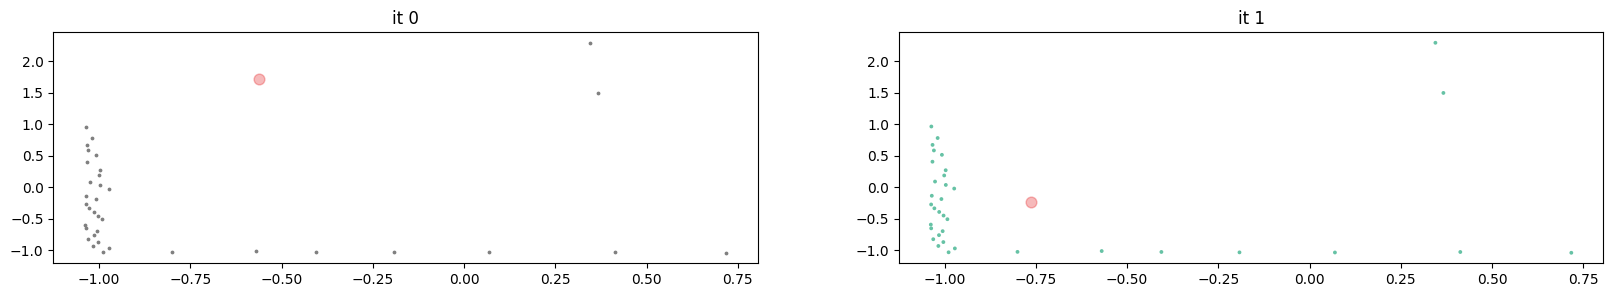

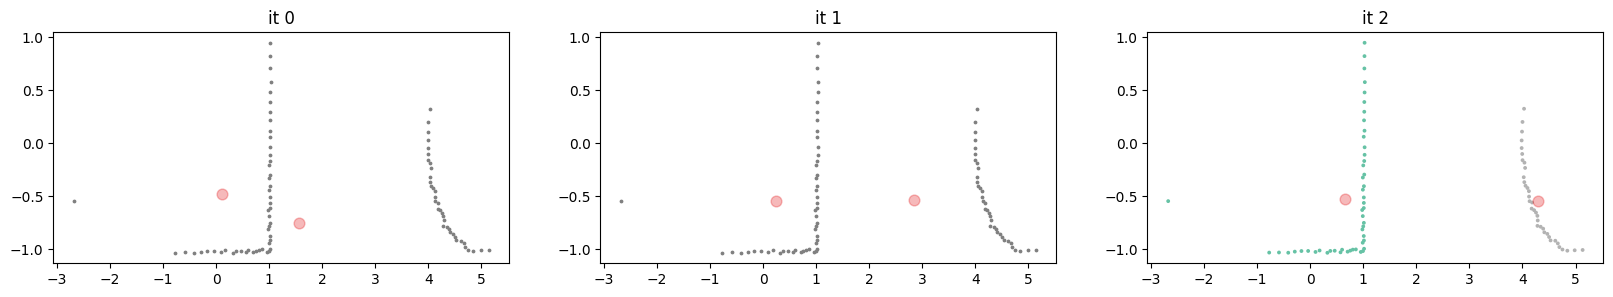

In [ ]:
# To complete
Lidar_range = df_test2obs.iloc[:, np.arange(2,362,1)].values
px = df_test2obs["px"].values
py = df_test2obs["py"].values

def kmeans_func(X_func, K_func, show_plot=0, ini_method=0):
  '''
    X_func are sample points;
    K_func is the number of clusters;
    showplot 0/1 - not / show centroid evolution over iterations;
    ini_method 0/1 - ini centroids 0=> with random within data bounderies or 1=>from the initial points (risky!)
  '''
  cluster = np.zeros(X_func.shape[0],dtype=int)
  centr_ini = []
  if ini_method:  # 1 is points, 0 is random
    # Initial centroids are sample points (risky!)
    for i in range(K_func):
      centr_ini.append(X_func[i])
  else:
    # Non absurd Random Initial Centroids
    max0 = max(X_func[:,0]);
    min0 = min(X_func[:,0]);
    max1 = max(X_func[:,1]);
    min1 = min(X_func[:,1]);

    for i in range(K_func):
      centr_ini.append([random.uniform(min0,max0),random.uniform(min1,max1)])

  iter = 0
  diff = 1
  centroids = centr_ini
  centr_list = [centroids]

  while diff:
    for sample_i, sample_pt in enumerate(X_func):
      min_dist = float('inf')
      # dist of the point from all centroids
      for centroid_i, centroid in enumerate(centroids):

        squared_diff = np.sum((centroid - sample_pt) ** 2)#######
        dist = np.sqrt(squared_diff)#########

        dist = np.sqrt((centroid[0]-sample_pt[0])**2 + (centroid[1]-sample_pt[1])**2)
        # store closest centroid
        if min_dist > dist:
          min_dist = dist
          cluster[sample_i] = centroid_i

    sum = np.zeros((K_func,2))
    cnt = np.zeros(K_func)
    for sample_i, sample_pt in enumerate(X_func):
      sum[cluster[sample_i]] += X_func[sample_i]
      cnt[cluster[sample_i]] += 1
    new_centroids = np.zeros((K_func,2))
    for k in range(K_func):
      if (cnt[k]>0):
        new_centroids[k] = sum[k] / cnt[k]
      else:
        # hopefully, the next iteration will fix uninteresting centroid
        new_centroids[k] = [random.uniform(min0,max0),random.uniform(min1,max1)]
    if np.count_nonzero(centroids-new_centroids) == 0:
      diff = 0
    else:
      centroids = new_centroids
      centr_list.append(new_centroids)
    iter=iter+1

  #print("Number of iterations", iter)
  if show_plot: # pretty subplotting
   cols = min(iter,6) # max 6 plots
   fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(20,3))
   for col in range(min(cols,iter)):
     if col < min(cols,iter)-1:
       ax[col].scatter(X_func[:, 0], X_func[:, 1], s=3, c='grey', cmap='Set1')
     else:
       ax[col].scatter(X_func[:, 0], X_func[:, 1], s=3, c=cluster, cmap='Set2')
     i = round(iter/cols*col)
     if (col == cols-1):
       i = iter-1
     ## print("centr %s", i,"=>", centr_list[i])
     ## devia funcionar ### ax[row, col].scatter(centr_list[i][:,0], centr_list[i][:,1], c='black', s=200, alpha=0.5);
     for j in range(K_func):
       centr_plot_x = centr_list[i][j][0]
       centr_plot_y = centr_list[i][j][1]
       ##print("centr_plot", j, "=> ", centr_plot_x, centr_plot_y)
       ax[col].scatter(centr_plot_x, centr_plot_y, c=j, s=60, alpha=0.3, cmap='Set1')
       ax[col].title.set_text("it " + str(i) )
   plt.show()

  return centroids, cluster


#Build the cloud points in 2D map
x_o, y_o = [], []

t=10*1
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

X = np.array([x_o, y_o]).T
centr, clust = kmeans_func(X, 1, show_plot=1, ini_method=0)
#print(clust)

x_o, y_o = [], []

t=10*32
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

X = np.array([x_o, y_o]).T
centr, clust = kmeans_func(X, 2, show_plot=1, ini_method=0)
#print(clust)

**2.2**
Using the previous results,
1. implement a method to automatically identify for each snapshot if it has 1 or 2 objects;
2. build a new test set with all the data in `data_test2obs.csv`, but now the new test set only has 1 object in each snapshot (and therefore this data set has more lines);
3. test this new data set using the ANN classifier.

Plot the position of the robot and the classified objects for some snapshots. What are the main conclusions?

**2.2 Conclusions**

When the cost difference between being one object or two exceeds a certain threshold, which in this case is 40, the snapshot is divided into two parts for classification. Even though a difference of around 20 already indicates the presence of two objects, the classification process requires at least 10 points to be more precise, making larger differences more reliable.

The snapshots chosen in the variable sample_indices, in this case [20, 200, 300, 400, 580] but clould take any values between 1 and 600, are separated into two snapshots if necessary, classified, and then the results of the prediction are plotted and printed.

Note that sometimes cluster_0 (blue) is assigned to the square and cluster_1 (red) is assigned to the circle, and vice versa. This occurs because the clustering process relies on random initialization values.

As shown in the plots with different colors, the separation into clusters is successfully achieved. The classification results printed under the plots also as expected.


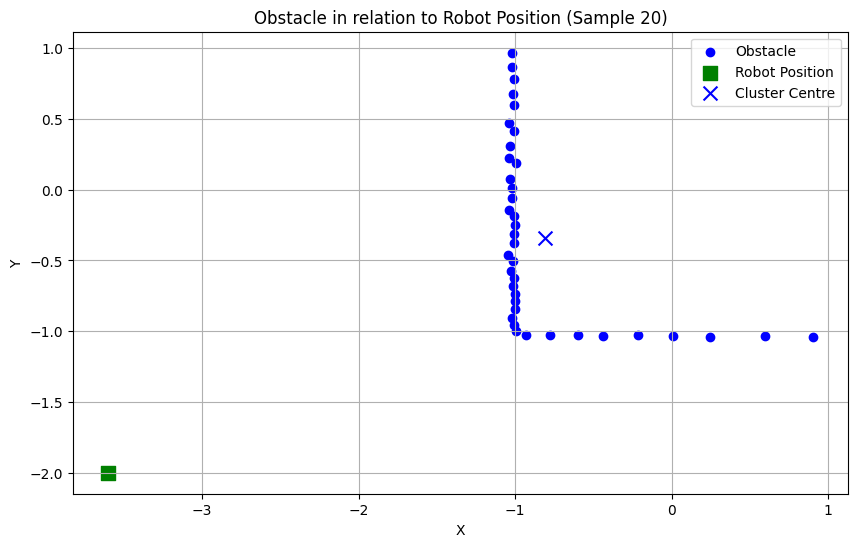

Sample number 20 has one Object
Classification Value:  1.0  --> Square


__________________________________________________________________________________________________________________





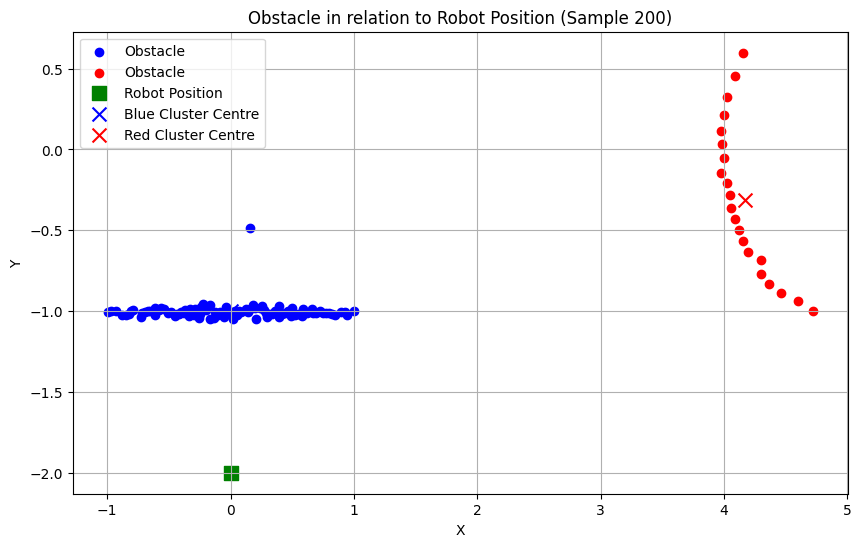

Sample number 200 has two Object
Blue Object Classification Value:  0.7636  --> Square
Red Object Classification Value:  0.0019  --> Circle


__________________________________________________________________________________________________________________





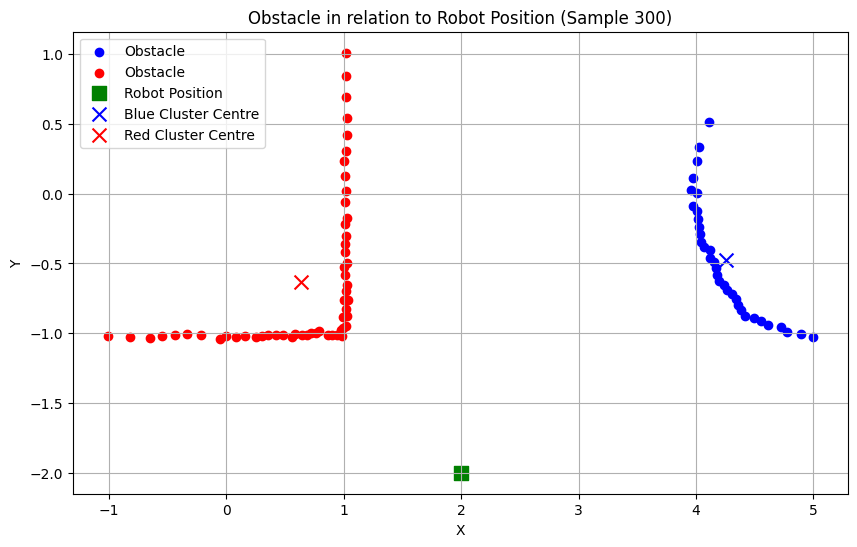

Sample number 300 has two Object
Blue Object Classification Value:  0.3806  --> Circle
Red Object Classification Value:  1.0  --> Square


__________________________________________________________________________________________________________________





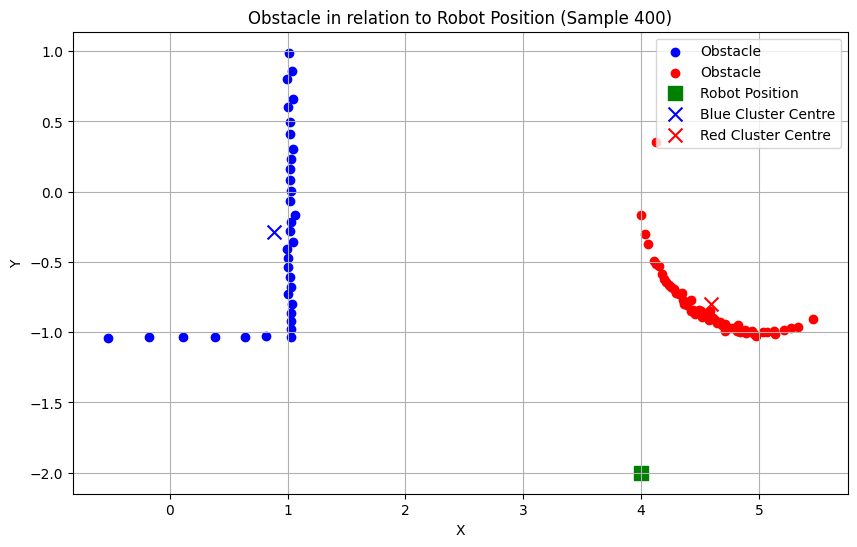

Sample number 400 has two Object
Blue Object Classification Value:  0.9877  --> Square
Red Object Classification Value:  0.0043  --> Circle


__________________________________________________________________________________________________________________





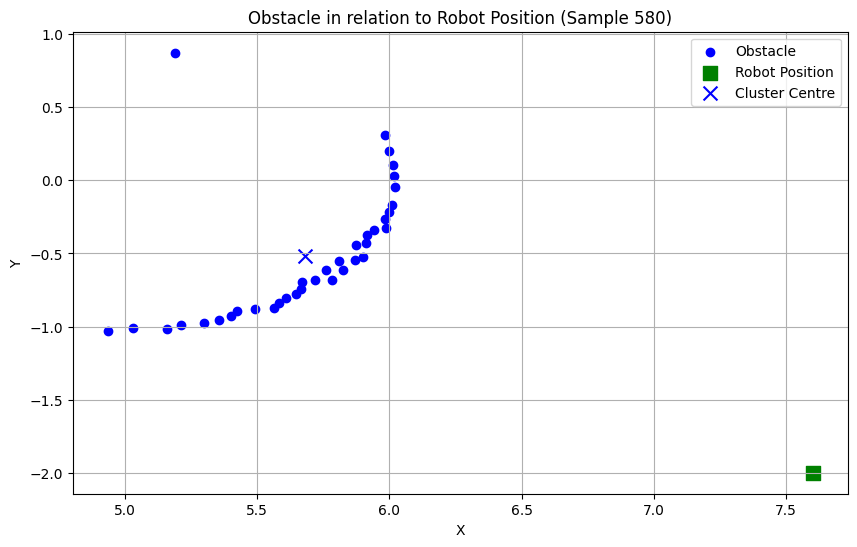

Sample number 580 has one Object
Classification Value:  0.3217  --> Circle


__________________________________________________________________________________________________________________





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#from some_module import df_test2obs, kmeans_func, model  # Adjust the import based on your actual module

# Parameters
Threshold = 40  # to decide if k=1 or k=2

# Extracting data from DataFrame
Lidar_range = df_test2obs.iloc[:, np.arange(2, 362, 1)].values
px = df_test2obs["px"].values
py = df_test2obs["py"].values

# Initialize variables
divided = []
#sample_indices = [i for i in range(1, 600)]
sample_indices = [20, 200, 300, 400, 580]
sample_data = {sample: {} for sample in sample_indices}

# Function to calculate Sum of Squared Error (SSE)
def SSE(X, centroids, cluster):
    sum = 0
    for i, val in enumerate(X):
        sum += np.sqrt((centroids[cluster[i], 0] - val[0])**2 + (centroids[cluster[i], 1] - val[1])**2)
    return sum

# Building the data set for ANN testing using k-means to split objects
test_set_X = np.array([])
px_new = []
py_new = []

for t in range(len(Lidar_range)):
    x_o = []
    y_o = []
    for i in range(len(Lidar_range[t])):
        if Lidar_range[t][i] > 0:
            x_o.append(px[t] + Lidar_range[t][i] * np.cos(angle[i] / 180 * np.pi))
            y_o.append(py[t] + Lidar_range[t][i] * np.sin(angle[i] / 180 * np.pi))
    X = np.array([x_o, y_o]).T
    cost_list = []

    # K-means clustering
    centr_1, clust_1 = kmeans_func(X, 1, show_plot=0, ini_method=0)
    cost = SSE(X, centr_1, clust_1)
    cost_list.append(cost)

    centr_2, clust_2 = kmeans_func(X, 2, show_plot=0, ini_method=0)
    cost = SSE(X, centr_2, clust_2)
    cost_list.append(cost)

    # Save data for the specified samples
    if t in sample_indices:
        sample_data[t] = {
            'x_o': x_o.copy(),
            'y_o': y_o.copy(),
            'px': px[t],
            'py': py[t],
            'centr_1': centr_1.copy(),
            'centr_2': centr_2.copy(),
            'clust_2': clust_2.copy()
        }

    # Determine if there is 1 or 2 obstacles
    N_INPUTS = len(Lidar_range[t])
    if (cost_list[0] - cost_list[1]) > Threshold:  # 20.0
        divided.append(1)
        px_new.append(px[t])
        py_new.append(py[t])
        px_new.append(px[t])
        py_new.append(py[t])

        # Prepare features for 2 objects
        X_feature1, X_feature2 = np.zeros([N_INPUTS]), np.zeros([N_INPUTS])
        j1, j2 = 0, 0
        for i in range(len(x_o)):
            if j1 < N_INPUTS and clust_2[i] == 0:
                X_feature1[j1] = np.sqrt((x_o[i] - px[t])**2 + (y_o[i] - py[t])**2)
                j1 += 1
            if j2 < N_INPUTS and clust_2[i] == 1:
                X_feature2[j2] = np.sqrt((x_o[i] - px[t])**2 + (y_o[i] - py[t])**2)
                j2 += 1
        if len(test_set_X) == 0:
            test_set_X = np.array([X_feature1, X_feature2])
        else:
            test_set_X = np.concatenate((test_set_X, np.array([X_feature1, X_feature2])))
    else:  # Only one object
        divided.append(0)
        px_new.append(px[t])
        py_new.append(py[t])
        X_feature1 = np.zeros([N_INPUTS])
        j1 = 0
        for i in range(len(x_o)):
            if j1 < N_INPUTS and clust_1[i] == 0:
                X_feature1[j1] = np.sqrt((x_o[i] - px[t])**2 + (y_o[i] - py[t])**2)
                j1 += 1
        if len(test_set_X) == 0:
            test_set_X = np.array([X_feature1])
        else:
            test_set_X = np.concatenate((test_set_X, np.array([X_feature1])))

# Calculate positions for classification
positions = {sample: 0 for sample in sample_indices}
current_pos = 0

for t in range(len(divided)):
    if divided[t] == 0:
        current_pos += 1
    if divided[t] == 1:
        current_pos += 2
    if t in sample_indices:
        positions[t] = current_pos

# Classify objects using the model
classification = []
for t in range(len(test_set_X)):
  X_trainrow = test_set_X[t].copy()
  X_trainrow_filter = []
  for value in X_trainrow:
    if value != 0:
        X_trainrow_filter.append(value)
    if len(X_trainrow_filter) == 10:
        break
  if(len(X_trainrow_filter)>=10):
    classification.append( model.feedforward(X_trainrow_filter) )
  else:
    classification.append( -10 )
classification = np.array(classification)

# Helper function to plot data
def plot_sample(px, py, x_o, y_o, centr_1, centr_2, clust_2, divided, sample, pos, title):
    x_o_clust_0 = []
    y_o_clust_0 = []
    x_o_clust_1 = []
    y_o_clust_1 = []

    for i in range(len(x_o)):
        if clust_2[i] == 0:
            x_o_clust_0.append(x_o[i])
            y_o_clust_0.append(y_o[i])
        else:
            x_o_clust_1.append(x_o[i])
            y_o_clust_1.append(y_o[i])

    plt.figure(figsize=(10, 6))
    if divided[sample] == 0:
        plt.scatter(x_o, y_o, label='Obstacle', color='blue', marker='o')
    else:
        plt.scatter(x_o_clust_0, y_o_clust_0, label='Obstacle', color='blue', marker='o')
        plt.scatter(x_o_clust_1, y_o_clust_1, label='Obstacle', color='red', marker='o')
    plt.scatter(px, py, color='g', s=100, marker="s", label="Robot Position")
    if divided[sample] == 0:
        plt.scatter(centr_1[0][0], centr_1[0][1], color='b', s=100, marker="x", label="Cluster Centre")
    else:
        plt.scatter(centr_2[0][0], centr_2[0][1], color='b', s=100, marker="x", label="Blue Cluster Centre")
        plt.scatter(centr_2[1][0], centr_2[1][1], color='r', s=100, marker="x", label="Red Cluster Centre")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

    if divided[sample] == 0:  # One object
        #print(centr_1)
        print("Sample number", sample, "has one Object")
        if classification[pos-1] == -10:
            print("Not enough data to classify")
            print("\n\n__________________________________________________________________________________________________________________\n\n\n")
        if classification[pos-1] < 0.5 and classification[pos-1] != -10:
            print("Classification Value: ", round(classification[pos-1], 4), " --> Circle")
            print("\n\n__________________________________________________________________________________________________________________\n\n\n")
        if classification[pos-1] >= 0.5:
            print("Classification Value: ", round(classification[pos-1], 4), " --> Square")
            print("\n\n__________________________________________________________________________________________________________________\n\n\n")
    else:  # Two objects
        print("Sample number", sample, "has two Object")
        if classification[pos-2] == -10:
            print("Not enough data to classify blue object")
            #print("\n\n__________________________________________________________________________________________________________________\n\n\n")
        if classification[pos - 2] < 0.5 and classification[pos-2] != -10:
            print("Blue Object Classification Value: ", round(classification[pos-2], 4), " --> Circle")
        if classification[pos-2] >= 0.5:
            print("Blue Object Classification Value: ", round(classification[pos-2], 4), " --> Square")
        if classification[pos-1] == -10:
            print("Not enough data to classify red object")
            print("\n\n__________________________________________________________________________________________________________________\n\n\n")
        if classification[pos-1] < 0.5 and classification[pos-1] != -10:
            print("Red Object Classification Value: ", round(classification[pos-1], 4), " --> Circle")
            print("\n\n__________________________________________________________________________________________________________________\n\n\n")
        if classification[pos-1] >= 0.5:
            print("Red Object Classification Value: ", round(classification[pos-1], 4), " --> Square")
            print("\n\n__________________________________________________________________________________________________________________\n\n\n")

# Plot and classify each sample
for sample in sample_indices:
    #print("POS: ", positions[sample])
    plot_sample(
        sample_data[sample]['px'],
        sample_data[sample]['py'],
        sample_data[sample]['x_o'],
        sample_data[sample]['y_o'],
        sample_data[sample]['centr_1'],
        sample_data[sample]['centr_2'],
        sample_data[sample]['clust_2'],
        divided,
        sample,
        positions[sample],
        f'Obstacle in relation to Robot Position (Sample {sample})'
    )

**2.3 (Extra)**
Using now PyTorch or other similar package, implement a better ANN (meaning with a better accuracy) and test it.

**Note:** This question is optional. If you solve it, you get extra 15 points (in 100).

In [ ]:
# To complete

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from tqdm.notebook import trange, tqdm



#X_test = df_test.iloc[:, np.arange(2,362,1)].values
#Y_test = df_test["label"].values


X_test = torch.tensor(df_train.iloc[:, np.arange(2, 362, 1)].values, dtype=torch.float32)  # CONVERSÃO PARA FLOAT32
Y_test = torch.tensor(df_train["label"].values, dtype=torch.float32)  # CONVERSÃO PARA FLOAT32
Y_test = Y_test - 1
X_realteste= torch.tensor(df_test.iloc[:, np.arange(2, 362, 1)].values, dtype=torch.float32)
Y_realteste = torch.tensor(df_test["label"].values, dtype=torch.float32)
Y_realteste=Y_realteste-1

class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        # Some init for my module

    def forward(self, x):
        # Function for performing the calculation of the module.
        return


class Classifier_Module(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1         = nn.Linear(num_inputs, num_hidden)
        self.activation_f1   = nn.ReLU()
        self.linear2         = nn.Linear(num_hidden, num_outputs)
        self.activation_sig  = nn.Sigmoid()           #  COMMENT if nn.BCEWithLogitsLoss is selected.

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.activation_f1(x)
        x = self.linear2(x)
        x = self.activation_sig(x)                   #  COMMENT if nn.BCEWithLogitsLoss is selected.
        return x


model = Classifier_Module(num_inputs=360, num_hidden=5, num_outputs=1)  # Ajustado para 360 entradas

# Printing a module shows all its submodules
#print(model)

'''# Specific model parameters
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

# All model parameter
model.state_dict()   #PyTorch assigns random values to these weights and biases'''
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels, std=0.1):
        """
        Inputs:
            data - Tensor com os dados de entrada
            labels - Tensor com os rótulos correspondentes
            std - Desvio padrão do ruído gaussiano a ser adicionado (opcional)
        """
        super().__init__()
        self.data = data
        self.labels = labels
        self.std = std

        # Adiciona ruído gaussiano se std for maior que 0
        #Esta mal ou n se usa isso ou a maneira como dou o dataset muda
        if self.std > 0:
           self.data = self.data + self.std * torch.randn_like(self.data)

    def __len__(self):
        # Retorna o número de amostras no dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Retorna a idx-ésima amostra e seu rótulo correspondente
        data_point = self.data[idx]
        data_label = self.labels[idx]
        return data_point, data_label


'''dataset = CustomDataset(X_test, Y_test)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)
data_inputs, data_labels = next(iter(data_loader))
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)'''

loss_module =  nn.BCELoss() # or nn.BCEWithLogitsLoss()  nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
train_dataset =  CustomDataset(X_test, Y_test)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)


# Push model to device. Has to be only done once
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

# Convert model parameters and buffers to CPU or CUDA
model.to(device)

def train_model(model, optimizer, dataloader, loss_criteria, num_epochs=1000):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in dataloader:

            ## Step 0 (needed in case of GPU): Move input data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # Step 1: setting gradients to zero. The gradients would not be overwritten but actually added to the existing ones.
            optimizer.zero_grad()

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            #preds = torch.sigmoid(preds)  # UNCOMMNET if nn.BCEWithLogitsLoss is selected.  Sigmoid to map predictions between 0 and 1. Be aware that the l

            ## Step 3: Calculate the loss
            loss = loss_criteria(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            loss.backward()

            ## Step 5: Update parameters based on the calculated gradients
            optimizer.step()

            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()

        # Add average loss to TensorBoard
        epoch_loss /= len(dataloader)

        if epoch % 5 == 0:
            print('[%d] loss: %.3f' % (epoch + 1, epoch_loss))


train_model(model, optimizer, train_data_loader, loss_module)

state_dict = model.state_dict()
torch.save(state_dict, "our_model.tar")

state_dict = torch.load("our_model.tar")

new_model = Classifier_Module(num_inputs=360, num_hidden=5, num_outputs=1)
new_model.load_state_dict(state_dict)

test_dataset=CustomDataset(X_realteste, Y_realteste)
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=True)


def eval_model(model, data_loader):
    # Set model to eval mode
    model.eval()

    true_preds, num_preds = 0., 0.

    # Deactivate gradients for the following code
    with torch.no_grad():

        # get batch of images from the test DataLoader
        for data_inputs, data_labels in data_loader:
            ## Step 0 (needed in case of GPU): Move input data to device
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            # Step 1: determine prediction of model
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]
            #preds = torch.sigmoid(preds)  # UNCOMMNET if nn.BCEWithLogitsLoss is selected.  Sigmoid to map predictions between 0 and 1. Be aware that the l

            # Step 2: Binarize predictions to 0 and 1
            pred_labels = (preds >= 0.5).long()

            # Step 3: Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

eval_model(model, train_data_loader)#agora usar o teste set e antes usar o train ?
eval_model(model, test_data_loader)

The model will be running on cpu device


  0%|          | 0/1000 [00:00<?, ?it/s]

[1] loss: 0.692
[6] loss: 0.657
[11] loss: 0.643
[16] loss: 0.630
[21] loss: 0.611
[26] loss: 0.586
[31] loss: 0.556
[36] loss: 0.525
[41] loss: 0.496
[46] loss: 0.472
[51] loss: 0.450
[56] loss: 0.427
[61] loss: 0.408
[66] loss: 0.391
[71] loss: 0.359
[76] loss: 0.345
[81] loss: 0.329
[86] loss: 0.314
[91] loss: 0.303
[96] loss: 0.292
[101] loss: 0.275
[106] loss: 0.274
[111] loss: 0.259
[116] loss: 0.264
[121] loss: 0.238
[126] loss: 0.240
[131] loss: 0.238
[136] loss: 0.222
[141] loss: 0.224
[146] loss: 0.216
[151] loss: 0.221
[156] loss: 0.209
[161] loss: 0.198
[166] loss: 0.184
[171] loss: 0.188
[176] loss: 0.180
[181] loss: 0.221
[186] loss: 0.169
[191] loss: 0.185
[196] loss: 0.163
[201] loss: 0.159
[206] loss: 0.164
[211] loss: 0.169
[216] loss: 0.154
[221] loss: 0.150
[226] loss: 0.143
[231] loss: 0.135
[236] loss: 0.131
[241] loss: 0.125
[246] loss: 0.158
[251] loss: 0.139
[256] loss: 0.118
[261] loss: 0.124
[266] loss: 0.115
[271] loss: 0.118
[276] loss: 0.108
[281] loss: 0.